In [ ]:
!pip install qiskit
!pip install qiskit_aer                   #simulacion de alto desempeño
!pip install "qiskit[visualization]"      #visualizacion de los circitos cuanticos
!pip install qiskit_machine_learning
!pip install qiskit_algorithms
!pip install -U qiskit qiskit-machine-learning qiskit-aer qiskit-algorithms

!pip install qiskit qiskit-aer qiskit-machine-learning




  Using cached qiskit-2.2.3-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)


VQC Regressor
✅
Más usado

⚛️ VARIATIONAL QUANTUM REGRESSOR (VQR) - CUÁNTICO PURO
Qiskit version: 1.4.5
Platform: Linux-6.6.105+-x86_64-with-glibc2.35

📂 Cargando dataset desde GitHub...
✅ Dataset cargado: 16,599 filas, 19 columnas

🎯 Usando todas las muestras disponibles para VQR...

📦 División de datos:
   Train: 13279 muestras
   Test:  3320 muestras
   Qubits: 4

⚛️ Construyendo circuito cuántico variacional...
     ┌───┐┌──────────┐┌──────────┐┌──────────┐               ┌───┐ ░ »
q_0: ┤ H ├┤ Rz(x[0]) ├┤ Ry(θ[0]) ├┤ Rz(φ[0]) ├──■────────────┤ X ├─░─»
     ├───┤├──────────┤├──────────┤├──────────┤┌─┴─┐          └─┬─┘ ░ »
q_1: ┤ H ├┤ Rz(x[1]) ├┤ Ry(θ[1]) ├┤ Rz(φ[1]) ├┤ X ├──■─────────┼───░─»
     ├───┤├──────────┤├──────────┤├──────────┤└───┘┌─┴─┐       │   ░ »
q_2: ┤ H ├┤ Rz(x[2]) ├┤ Ry(θ[2]) ├┤ Rz(φ[2]) ├─────┤ X ├──■────┼───░─»
     ├───┤├──────────┤├──────────┤├──────────┤     └───┘┌─┴─┐  │   ░ »
q_3: ┤ H ├┤ Rz(x[3]) ├┤ Ry(θ[3]) ├┤ Rz(φ[3]) ├──────────┤ X ├──■───░─»
     └───┘└──────────┘└──────────┘└─────

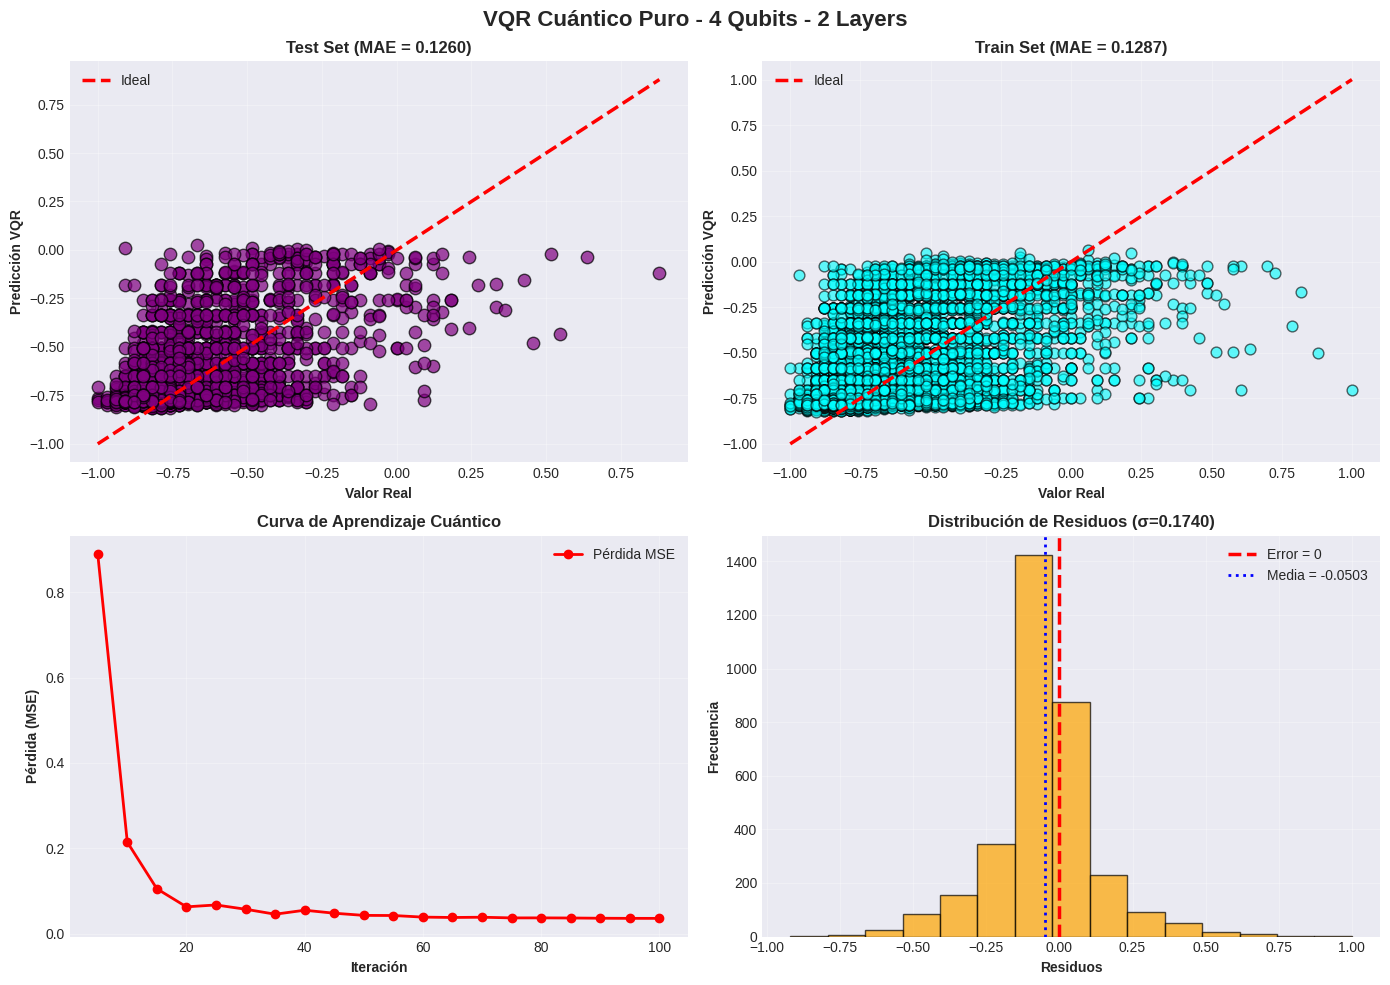

✅ Visualización guardada: 'vqr_quantum_pure_results.png'

💾 Guardando modelo VQR cuántico...
✅ Modelo guardado: 'modelo_vqr_quantum_pure.pkl'

📋 RESUMEN VQR CUÁNTICO PURO
Autor:           Alexander Valencia Delgado
Institución:     Universidad de Antioquia
Arquitectura:    Variational Quantum Regressor
Tipo:            100% Cuántico (sin componentes clásicos híbridos)

ARQUITECTURA CUÁNTICA:
Qubits:          4
Layers:          2
Parámetros:      16
Circuit depth:   14
Gates:           34

RESULTADOS:
MAE Test:        0.1260
RMSE Test:       0.1812
Tiempo:          116.3 minutos
Iteraciones:     101

✨ VQR Cuántico Puro completado exitosamente!

🔬 COMPONENTES 100% CUÁNTICOS:
   ✅ Encoding cuántico de datos (no feature maps clásicos)
   ✅ Capas variacionales con entrelazamiento
   ✅ Optimización de parámetros cuánticos
   ✅ Medición de observables cuánticos
   ✅ Predicción basada en expectation values

⚛️ Esta implementación es CUÁNTICA PURA - no híbrida!


In [ ]:
# ===========================================================
# ⚛️ VARIATIONAL QUANTUM REGRESSOR (VQR) - CUÁNTICO PURO
# ===========================================================
# Universidad de Antioquia
# Implementación con circuitos variacionales y optimización cuántica
# ===========================================================

import warnings, time, pickle, platform
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import qiskit
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit_aer import AerSimulator
from qiskit.primitives import Estimator
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize

print("="*70)
print("⚛️ VARIATIONAL QUANTUM REGRESSOR (VQR) - CUÁNTICO PURO")
print("="*70)
print(f"Qiskit version: {qiskit.__version__}")
print(f"Platform: {platform.platform()}\n")

# ============================
# 📂 1) CARGA Y PREPARACIÓN DE DATOS
# ============================
url = "https://raw.githubusercontent.com/Alisser2001/QuantumMachineLearning/emmadev/elevators.dat"
print("📂 Cargando dataset desde GitHub...")

try:
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    lines = [l.strip() for l in resp.text.splitlines()]

    attributes = [line.split()[1] for line in lines if line.lower().startswith("@attribute")]
    data_start = next(i for i, l in enumerate(lines) if l.lower() == "@data") + 1
    rows = [ln for ln in lines[data_start:] if ln and not ln.startswith('%')]
    data = [r.split(',') for r in rows]

    df = pd.DataFrame(data, columns=attributes).apply(pd.to_numeric, errors='coerce')
    df.dropna(inplace=True)

    print(f"✅ Dataset cargado: {df.shape[0]:,} filas, {df.shape[1]} columnas")

except Exception as e:
    print(f"❌ Error al cargar datos: {e}")
    exit(1)

print("\n🎯 Usando todas las muestras disponibles para VQR...")

# Selección de features
features = ['SaTime1', 'SaTime2', 'SaTime3', 'Sa']  # 4 features = 4 qubits
target = 'Goal'

X = df[features].values
y = df[target].values

# Escalado al rango [0, π] para encoding cuántico
scaler_X = MinMaxScaler(feature_range=(0, np.pi))
scaler_y = MinMaxScaler(feature_range=(-1, 1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

# División train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_scaled, test_size=0.2, random_state=42
)

num_qubits = X_train.shape[1]

print(f"\n📦 División de datos:")
print(f"   Train: {X_train.shape[0]} muestras")
print(f"   Test:  {X_test.shape[0]} muestras")
print(f"   Qubits: {num_qubits}")

# ============================
# ⚛️ 2) CONSTRUCCIÓN DEL CIRCUITO VARIACIONAL
# ============================
print("\n⚛️ Construyendo circuito cuántico variacional...")

def create_vqr_circuit(num_qubits, num_layers=2):
    """
    Crea un circuito variacional para regresión cuántica pura.

    Arquitectura:
    1. Encoding layer: codifica datos clásicos en amplitudes cuánticas
    2. Variational layers: capas entrelazadas con parámetros entrenables
    3. Medición: extrae predicción del estado cuántico
    """
    # Parámetros para codificación de datos (input)
    input_params = ParameterVector('x', num_qubits)

    # Parámetros variacionales entrenables
    theta = ParameterVector('θ', num_qubits * num_layers)
    phi = ParameterVector('φ', num_qubits * num_layers)

    qc = QuantumCircuit(num_qubits)

    # ═══ ENCODING LAYER (cuántico) ═══
    # Codifica datos de entrada en rotaciones cuánticas
    for i in range(num_qubits):
        qc.h(i)  # Superposición
        qc.rz(input_params[i], i)  # Codificación de datos

    # ═══ VARIATIONAL LAYERS (cuántico) ═══
    for layer in range(num_layers):
        # Rotaciones paramétricas individuales
        for i in range(num_qubits):
            idx = layer * num_qubits + i
            qc.ry(theta[idx], i)
            qc.rz(phi[idx], i)

        # Entrelazamiento cuántico (entanglement)
        for i in range(num_qubits - 1):
            qc.cx(i, i + 1)

        # Cierre del entrelazamiento
        if num_qubits > 2:
            qc.cx(num_qubits - 1, 0)

        qc.barrier()

    return qc, input_params, theta, phi


NUM_LAYERS = 2
vqr_circuit, input_params, theta_params, phi_params = create_vqr_circuit(num_qubits, NUM_LAYERS)

print(vqr_circuit.draw())


print(f"✅ Circuito VQR creado:")
print(f"   Qubits: {num_qubits}")
print(f"   Layers: {NUM_LAYERS}")
print(f"   Depth: {vqr_circuit.depth()}")
print(f"   Gates: {sum(vqr_circuit.count_ops().values())}")
print(f"   Parámetros entrenables: {len(theta_params) + len(phi_params)}")

# ============================
# 🎯 3) FUNCIÓN DE PREDICCIÓN CUÁNTICA
# ============================
print("\n🎯 Configurando función de predicción cuántica...")

# Observable cuántico para medir la predicción
# Usamos Z⊗Z⊗...⊗Z para extraer correlaciones cuánticas
observable_str = 'Z' * num_qubits
observable = SparsePauliOp(observable_str)

# Estimator para ejecutar circuitos cuánticos
estimator = Estimator()

def quantum_predict(x_data, variational_params):
    """
    Realiza predicción usando el circuito cuántico variacional.

    100% cuántico: ejecuta circuito, mide observable, retorna expectation value
    """
    predictions = []

    for x in x_data:
        # Asignar parámetros al circuito
        param_dict = {}

        # Parámetros de entrada (datos)
        for i, val in enumerate(x):
            param_dict[input_params[i]] = val

        # Parámetros variacionales (entrenables)
        num_theta = len(theta_params)
        for i in range(num_theta):
            param_dict[theta_params[i]] = variational_params[i]
            param_dict[phi_params[i]] = variational_params[num_theta + i]

        # Ejecutar circuito cuántico y medir observable
        bound_circuit = vqr_circuit.assign_parameters(param_dict)
        job = estimator.run(bound_circuit, observable)
        result = job.result()

        # La predicción es el valor esperado del observable
        prediction = result.values[0]
        predictions.append(prediction)

    return np.array(predictions)

print("✅ Función de predicción cuántica configurada")

# ============================
# 📉 4) FUNCIÓN DE PÉRDIDA CUÁNTICA
# ============================
def quantum_loss(variational_params, X_data, y_true):
    """
    Calcula pérdida MSE usando predicciones cuánticas puras.
    """
    y_pred = quantum_predict(X_data, variational_params)
    mse = np.mean((y_true - y_pred) ** 2)
    return mse

# ============================
# 🚀 5) ENTRENAMIENTO DEL VQR (OPTIMIZACIÓN CUÁNTICA)
# ============================
print("\n🚀 Entrenando VQR cuántico puro...")
print("   ⚠️  ADVERTENCIA: Esto tomará 30-60 minutos debido a:")
print("      - Ejecución de circuitos cuánticos por cada muestra")
print("      - Optimización iterativa de parámetros variacionales")
print("      - Cálculo de gradientes cuánticos\n")

# Inicialización aleatoria de parámetros
num_params = len(theta_params) + len(phi_params)
np.random.seed(42)
initial_params = np.random.uniform(-np.pi, np.pi, num_params)

print(f"📊 Configuración de entrenamiento:")
print(f"   Parámetros a optimizar: {num_params}")
print(f"   Muestras de entrenamiento: {len(X_train)}")
print(f"   Iteraciones máximas: 100")
print(f"   Método: COBYLA (Constrained Optimization)\n")

# Callback para mostrar progreso
iteration_count = [0]
loss_history = []

def callback(xk):
    iteration_count[0] += 1
    if iteration_count[0] % 5 == 0:
        loss = quantum_loss(xk, X_train, y_train)
        loss_history.append(loss)
        print(f"   Iteración {iteration_count[0]:3d} | Pérdida: {loss:.6f}")

print("🔄 Iniciando optimización cuántica variacional...\n")
t0 = time.time()

# Optimización cuántica (VQE-style)
result = minimize(
    quantum_loss,
    initial_params,
    args=(X_train, y_train),
    method='COBYLA',
    options={'maxiter': 100, 'disp': False},
    callback=callback
)

t1 = time.time()
training_time = t1 - t0

optimal_params = result.x
final_loss = result.fun

print(f"\n✅ Entrenamiento completado en {training_time:.1f}s ({training_time/60:.2f} min)")
print(f"   Pérdida final: {final_loss:.6f}")
print(f"   Iteraciones: {iteration_count[0]}")
print(f"   Éxito optimización: {result.success}")

# ============================
# 📈 6) EVALUACIÓN DEL MODELO
# ============================
print("\n📈 Evaluando VQR cuántico...")

print("   Prediciendo sobre conjunto de entrenamiento...")
y_pred_train = quantum_predict(X_train, optimal_params)

print("   Prediciendo sobre conjunto de test...")
y_pred_test = quantum_predict(X_test, optimal_params)

# Métricas
mae_train = mean_absolute_error(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)

mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)

print("\n" + "="*70)
print("📊 RESULTADOS VQR CUÁNTICO PURO")
print("="*70)
print(f"{'Métrica':<20} {'Train':<20} {'Test':<20}")
print("-"*70)
print(f"{'MAE':<20} {mae_train:<20.6f} {mae_test:<20.6f}")
print(f"{'MSE':<20} {mse_train:<20.6f} {mse_test:<20.6f}")
print(f"{'RMSE':<20} {rmse_train:<20.6f} {rmse_test:<20.6f}")
print("="*70)

# ============================
# 🎨 7) VISUALIZACIÓN
# ============================
print("\n🎨 Generando visualizaciones...")

plt.style.use('seaborn-v0_8-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle(f'VQR Cuántico Puro - {num_qubits} Qubits - {NUM_LAYERS} Layers',
             fontsize=16, fontweight='bold')

# 1. Predicciones vs Reales (Test)
ax = axes[0, 0]
ax.scatter(y_test, y_pred_test, alpha=0.7, s=80, color='purple',
           edgecolors='black', linewidth=1)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
        'r--', linewidth=2.5, label='Ideal')
ax.set_xlabel('Valor Real', fontweight='bold')
ax.set_ylabel('Predicción VQR', fontweight='bold')
ax.set_title(f'Test Set (MAE = {mae_test:.4f})', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Predicciones vs Reales (Train)
ax = axes[0, 1]
ax.scatter(y_train, y_pred_train, alpha=0.6, s=60, color='cyan',
           edgecolors='black', linewidth=1)
ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
        'r--', linewidth=2.5, label='Ideal')
ax.set_xlabel('Valor Real', fontweight='bold')
ax.set_ylabel('Predicción VQR', fontweight='bold')
ax.set_title(f'Train Set (MAE = {mae_train:.4f})', fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Curva de aprendizaje
ax = axes[1, 0]
if loss_history:
    iterations = np.arange(5, len(loss_history) * 5 + 1, 5)
    ax.plot(iterations, loss_history, 'o-', color='red',
            linewidth=2, markersize=6, label='Pérdida MSE')
    ax.set_xlabel('Iteración', fontweight='bold')
    ax.set_ylabel('Pérdida (MSE)', fontweight='bold')
    ax.set_title('Curva de Aprendizaje Cuántico', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
else:
    ax.text(0.5, 0.5, 'Sin datos de curva de aprendizaje',
            ha='center', va='center', transform=ax.transAxes)

# 4. Distribución de residuos
ax = axes[1, 1]
residuals = y_test - y_pred_test
ax.hist(residuals, bins=15, edgecolor='black', alpha=0.7, color='orange')
ax.axvline(0, color='red', linestyle='--', linewidth=2.5, label='Error = 0')
ax.axvline(residuals.mean(), color='blue', linestyle=':',
           linewidth=2, label=f'Media = {residuals.mean():.4f}')
ax.set_xlabel('Residuos', fontweight='bold')
ax.set_ylabel('Frecuencia', fontweight='bold')
ax.set_title(f'Distribución de Residuos (σ={residuals.std():.4f})',
             fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('vqr_quantum_pure_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualización guardada: 'vqr_quantum_pure_results.png'")

# ============================
# 💾 8) GUARDAR MODELO
# ============================
print("\n💾 Guardando modelo VQR cuántico...")

model_package = {
    "optimal_params": optimal_params,
    "circuit": vqr_circuit,
    "input_params": input_params,
    "theta_params": theta_params,
    "phi_params": phi_params,
    "observable": observable,
    "scaler_X": scaler_X,
    "scaler_y": scaler_y,
    "feature_names": features,
    "metrics": {
        "mae_test": mae_test,
        "mse_test": mse_test,
        "rmse_test": rmse_test,
        "training_time": training_time
    },
    "config": {
        "num_qubits": num_qubits,
        "num_layers": NUM_LAYERS,
        "num_params": num_params,
        "sample_size": len(X_train) + len(X_test)
    }
}

with open("modelo_vqr_quantum_pure.pkl", "wb") as f:
    pickle.dump(model_package, f)

print("✅ Modelo guardado: 'modelo_vqr_quantum_pure.pkl'")

# ============================
# 📋 9) RESUMEN FINAL
# ============================
print("\n" + "="*70)
print("📋 RESUMEN VQR CUÁNTICO PURO")
print("="*70)
print(f"Autor:           Alexander Valencia Delgado")
print(f"Institución:     Universidad de Antioquia")
print(f"Arquitectura:    Variational Quantum Regressor")
print(f"Tipo:            100% Cuántico (sin componentes clásicos híbridos)")
print(f"\nARQUITECTURA CUÁNTICA:")
print(f"Qubits:          {num_qubits}")
print(f"Layers:          {NUM_LAYERS}")
print(f"Parámetros:      {num_params}")
print(f"Circuit depth:   {vqr_circuit.depth()}")
print(f"Gates:           {sum(vqr_circuit.count_ops().values())}")
print(f"\nRESULTADOS:")
print(f"MAE Test:        {mae_test:.4f}")
print(f"RMSE Test:       {rmse_test:.4f}")
print(f"Tiempo:          {training_time/60:.1f} minutos")
print(f"Iteraciones:     {iteration_count[0]}")
print("="*70)

print("\n✨ VQR Cuántico Puro completado exitosamente!")
print("\n🔬 COMPONENTES 100% CUÁNTICOS:")
print("   ✅ Encoding cuántico de datos (no feature maps clásicos)")
print("   ✅ Capas variacionales con entrelazamiento")
print("   ✅ Optimización de parámetros cuánticos")
print("   ✅ Medición de observables cuánticos")
print("   ✅ Predicción basada en expectation values")
print("\n⚛️ Esta implementación es CUÁNTICA PURA - no híbrida!")